# Image Classification - Intel Image Classification

## Import Libraries

In [1]:
# Install TensorFlow version 2.15
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
# Import necessary libraries
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from google.colab import files

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121, InceptionV3

In [3]:
tf.__version__

'2.15.0'

## Data Preparation

In [4]:
# Prompt the user to upload the kaggle.json file
uploaded = files.upload()

# Create the .kaggle directory in your home directory (if it doesn't exist)
!mkdir -p ~/.kaggle

# Move the uploaded kaggle.json file to the ~/.kaggle directory
!mv kaggle.json ~/.kaggle/

# Set the permissions for kaggle.json to ensure it's secure
!chmod 600 ~/.kaggle/kaggle.json

# Verify if the file is correctly placed by listing the contents of the .kaggle directory
!ls -lha ~/.kaggle/

# (Optional) Remove kaggle.json from the current working directory to ensure there's only one copy
!rm -f kaggle.json

# Download the dataset directly into the 'data' directory
!kaggle datasets download -d puneet6060/intel-image-classification -p ./data

# Unzip the downloaded dataset into the 'data' directory
!unzip ./data/intel-image-classification.zip -d ./data

# Remove the zip file to clean up the environment
!rm ./data/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./data/seg_train/seg_train/mountain/7506.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7537.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7539.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7551.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7560.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7565.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7578.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7581.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7586.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7647.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7652.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7654.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7662.jpg  
  inflating: ./data/seg_train/seg_train/mountain/767.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7672.jpg  
  inflating: ./data/seg_train/seg_train/mountain/7

##### *Data Loading*

In [5]:
# Define the paths to training and test data
train_dir = './data/seg_train/seg_train'
test_dir = './data/seg_test/seg_test'

# Get the category labels from the folder names
categories = [folder_name for folder_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder_name))]

# Print the categories to verify
print("Categories:", categories)

Categories: ['sea', 'street', 'buildings', 'mountain', 'forest', 'glacier']


This code snippet sets up the paths to the training and test datasets, which are stored in the `seg_train/seg_train` and `seg_test/seg_test` directories, respectively. The `categories` list is dynamically generated by extracting the folder names within the training directory, each representing a distinct category or class in the dataset.

##### *Data Distribution*

In [6]:
# Initialize dictionaries to store counts for each category
train_counts = {}
test_counts = {}

# Calculate the total number of images in each category in train_dir
for category in categories:
    train_category_path = os.path.join(train_dir, category)
    train_counts[category] = len([img for img in os.listdir(train_category_path) if img.endswith(('.jpg', '.jpeg', '.png'))])

# Calculate the total number of images in each category in test_dir
for category in categories:
    test_category_path = os.path.join(test_dir, category)
    test_counts[category] = len([img for img in os.listdir(test_category_path) if img.endswith(('.jpg', '.jpeg', '.png'))])

# Print the results
print("Train directory data:")
for category, count in train_counts.items():
    print(f"  {category}: {count} images")

print("\nTest directory data:")
for category, count in test_counts.items():
    print(f"  {category}: {count} images")

# Calculate total images in train_dir and test_dir
total_train_images = sum(train_counts.values())
total_test_images = sum(test_counts.values())

print(f"\nTotal images in train_dir: {total_train_images}")
print(f"Total images in test_dir: {total_test_images}")

Train directory data:
  sea: 2274 images
  street: 2382 images
  buildings: 2191 images
  mountain: 2512 images
  forest: 2271 images
  glacier: 2404 images

Test directory data:
  sea: 510 images
  street: 501 images
  buildings: 437 images
  mountain: 525 images
  forest: 474 images
  glacier: 553 images

Total images in train_dir: 14034
Total images in test_dir: 3000


In [7]:
# Define the paths to training and test data
train_dir = './data/seg_train/seg_train'
test_dir = './data/seg_test/seg_test'

# Get the category labels from the folder names
categories = [folder_name for folder_name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder_name))]

# Initialize lists to store file paths and labels
all_images = []
all_labels = []

# Combine all images from both train_dir and test_dir
for category in categories:
    # Collect images from train_dir
    train_category_path = os.path.join(train_dir, category)
    train_images = [os.path.join(train_category_path, img) for img in os.listdir(train_category_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

    # Collect images from test_dir
    test_category_path = os.path.join(test_dir, category)
    test_images = [os.path.join(test_category_path, img) for img in os.listdir(test_category_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

    # Append all images and corresponding labels
    all_images.extend(train_images)
    all_labels.extend([category] * len(train_images))
    all_images.extend(test_images)
    all_labels.extend([category] * len(test_images))

# Verify if the number of images matches the number of labels
assert len(all_images) == len(all_labels), f"Inconsistent data: {len(all_images)} images and {len(all_labels)} labels"

# Total number of images
total_images = len(all_images)

# Split the combined dataset into 80% train and 20% test
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, train_size=0.8, random_state=42, stratify=all_labels)

# Print out the number of images in each set to verify
print(f"Total images: {total_images}")
print(f"Training images: {len(train_images)} ({len(train_images) / total_images * 100:.2f}%)")
print(f"Testing images: {len(test_images)} ({len(test_images) / total_images * 100:.2f}%)")

# Print category-wise distribution
print("\nTraining set distribution by category:")
for category in categories:
    print(f"  {category}: {train_labels.count(category)} images")

print("\nTest set distribution by category:")
for category in categories:
    print(f"  {category}: {test_labels.count(category)} images")


Total images: 17034
Training images: 13627 (80.00%)
Testing images: 3407 (20.00%)

Training set distribution by category:
  sea: 2227 images
  street: 2306 images
  buildings: 2102 images
  mountain: 2430 images
  forest: 2196 images
  glacier: 2366 images

Test set distribution by category:
  sea: 557 images
  street: 577 images
  buildings: 526 images
  mountain: 607 images
  forest: 549 images
  glacier: 591 images


##### *Data Distribution Visualization*

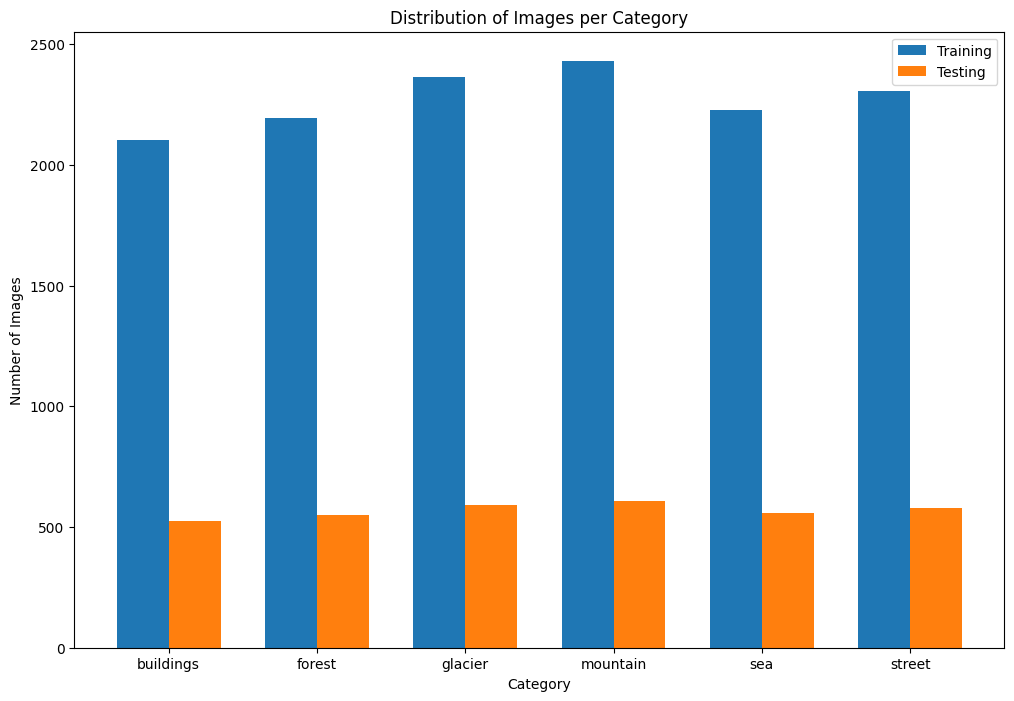

In [8]:
# Count the number of images per category in each set
train_counts = {cat: train_labels.count(cat) for cat in categories}
test_counts = {cat: test_labels.count(cat) for cat in categories}

# Sort categories for consistent plotting
categories_sorted = sorted(categories)
x = range(len(categories_sorted))  # x-axis positions
bar_width = 0.35  # Width of the bars (adjusted for two sets)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting training and testing data
ax.bar([i - bar_width/2 for i in x], [train_counts[cat] for cat in categories_sorted],
       width=bar_width, label='Training')
ax.bar([i + bar_width/2 for i in x], [test_counts[cat] for cat in categories_sorted],
       width=bar_width, label='Testing')

# Adding labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images per Category')
ax.set_xticks(x)
ax.set_xticklabels(categories_sorted)
ax.legend()

plt.show()

1. **Balanced Distribution**:
   - The bar chart indicates a well-balanced distribution of images across all categories (`buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`) in the training and testing sets.
   - Each category has a similar number of images in the training set, as shown by the heights of the first set of bars.
   - Similarly, the testing set (second set of bars) is also balanced across categories, ensuring consistent evaluation.

2. **Proportion of Sets**:
   - The training set has the highest number of images for each category, which is expected since 80% of the data is allocated for training.
   - The testing set has fewer images, approximately 20% of the total data, consistent with the allocation for testing.
   - This distribution is important as it ensures that the model has enough data to learn from while also being properly evaluated on a separate set of data.

3. **Category-wise Consistency**:
   - There is consistency in the distribution across all categories, meaning that no single category is underrepresented or overrepresented.
   - This consistency is crucial for training a model that can generalize well across all categories.

### Data Preprocessing

In [9]:
# Define image dimensions
img_height, img_width = 150, 150
batch_size = 32

In this section, the image dimensions and batch size are defined, which are crucial parameters for preprocessing the images and training the model:

- **`img_height` and `img_width`**:
  - These variables define the target size for all input images, which will be resized to 150x150 pixels. This standardization ensures that all images fed into the model have the same dimensions, making the input data consistent and easier for the model to process.

- **`batch_size`**:
  - This variable determines the number of images that will be processed together in one batch during training. A batch size of 32 means that the model will update its weights after processing 32 images in each iteration, balancing between computational efficiency and learning speed.

##### *Train Data*

In [10]:
# Initialize an enhanced ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=30,           # Increased random rotation range
    width_shift_range=0.3,       # Larger random horizontal shifts
    height_shift_range=0.3,      # Larger random vertical shifts
    zoom_range=0.3,              # Larger random zoom
    shear_range=0.2,             # Shear transformations
    brightness_range=[0.8, 1.2], # Random brightness adjustments
    horizontal_flip=True,        # Allow horizontal flips
    vertical_flip=True,          # Allow vertical flips
    fill_mode='nearest'          # Filling in newly created pixels
)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle for training
)

Found 13627 validated image filenames belonging to 6 classes.


##### *Test Data*

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_images, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No shuffle for testing
)

Found 3407 validated image filenames belonging to 6 classes.


##### *Data Preview*

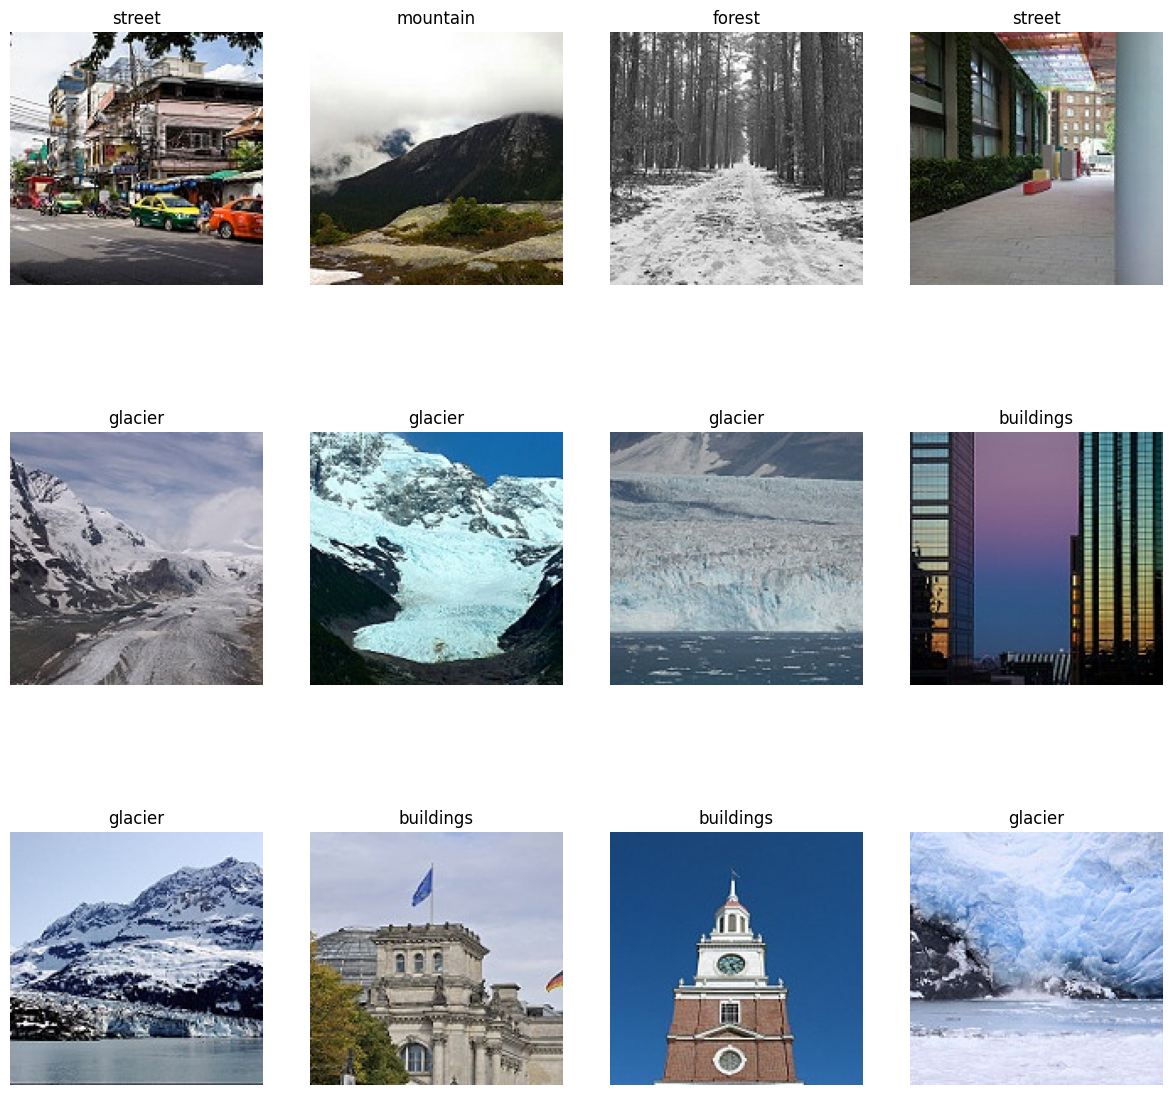

In [12]:
# Define the number of rows and columns for the grid
rows, cols = 3, 4

# Initialize a figure
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.tight_layout(pad=0)  # Add some padding between images

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize image index
img_idx = 0

# Display a grid of training images
for img_path in train_images[:rows * cols]:  # Select the first `rows * cols` images from the training set
    # Construct the correct full image path
    full_img_path = img_path

    # Attempt to load the image using PIL
    try:
        img = Image.open(full_img_path)
        img = img.convert('RGB')  # Ensure the image is in RGB mode
        img = img.resize((150, 150))  # Resize image to match the input size of the model
        img = np.array(img)  # Convert to numpy array

        # Display the image
        axes[img_idx].imshow(img)
        label = os.path.split(os.path.split(img_path)[0])[1]  # Extract label from the path
        axes[img_idx].set_title(label)
        axes[img_idx].axis('off')  # Hide the axes for better visualization
        img_idx += 1

    except Exception as e:
        print(f"Warning: Image at {full_img_path} could not be loaded. Error: {e}")
        continue

# Hide any remaining empty axes
for i in range(img_idx, rows * cols):
    axes[i].axis('off')

plt.show()

## Modeling

In [13]:
# Create the Sequential model
model = Sequential([
    # Input layer for the model with specified input shape
    Input(shape=(150, 150, 3)),

    # InceptionV3 model as a feature extractor (pre-trained on ImageNet)
    InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3)),

    # First Conv2D block after InceptionV3 with Batch Normalization and MaxPooling
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding='same'),  # Use 'same' padding to maintain spatial dimensions
    Dropout(0.5),  # Dropout to prevent overfitting

    # Second Conv2D block with increased filters for greater model complexity
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    # Flatten the feature maps into a 1D vector
    Flatten(),

    # First fully connected layer with 256 neurons and ReLU activation
    Dense(256, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Second fully connected layer with 128 neurons and ReLU activation
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output layer with softmax activation for multi-class classification
    Dense(len(categories), activation='softmax')
])

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model's architecture
model.summary()


87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 3, 3, 128)         2359424   
                                                                 
 batch_normalization_94 (Ba  (None, 3, 3, 128)         512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 128)         0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 2, 2, 128)         0         
                                                         

In [14]:
# Compile the model with an optimizer and a reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the accuracy and validation accuracy from logs
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if accuracy >= 0.95 and val_accuracy >= 0.95:
            print("\nAccuracy and Validation Accuracy have reached 95%, stopping training...")
            self.model.stop_training = True

# Example usage of the CustomEarlyStopping callback
early_stopping_callback = CustomEarlyStopping()

In this code, a custom callback class named `CustomEarlyStopping` is created to stop the training process automatically when the model achieves an accuracy of 95% or higher on both the training and validation sets.

In [16]:
# Use a callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001, verbose=1)

In [17]:
# Train the model using the fit method
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[reduce_lr, early_stopping_callback]
)

Epoch 1/30
426/426 [==============================] - 132s 220ms/step - loss: 2.0939 - accuracy: 0.2890 - val_loss: 1.0979 - val_accuracy: 0.5295 - lr: 1.0000e-04
Epoch 2/30
426/426 [==============================] - 90s 211ms/step - loss: 1.2220 - accuracy: 0.5165 - val_loss: 0.6300 - val_accuracy: 0.8042 - lr: 1.0000e-04
Epoch 3/30
426/426 [==============================] - 90s 212ms/step - loss: 0.9377 - accuracy: 0.6409 - val_loss: 0.4289 - val_accuracy: 0.8691 - lr: 1.0000e-04
Epoch 4/30
426/426 [==============================] - 91s 213ms/step - loss: 0.7283 - accuracy: 0.7483 - val_loss: 0.3407 - val_accuracy: 0.8929 - lr: 1.0000e-04
Epoch 5/30
426/426 [==============================] - 90s 211ms/step - loss: 0.6513 - accuracy: 0.7862 - val_loss: 0.3252 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 6/30
426/426 [==============================] - 91s 213ms/step - loss: 0.5808 - accuracy: 0.8108 - val_loss: 0.3036 - val_accuracy: 0.8970 - lr: 1.0000e-04
Epoch 7/30
426/426 [=======

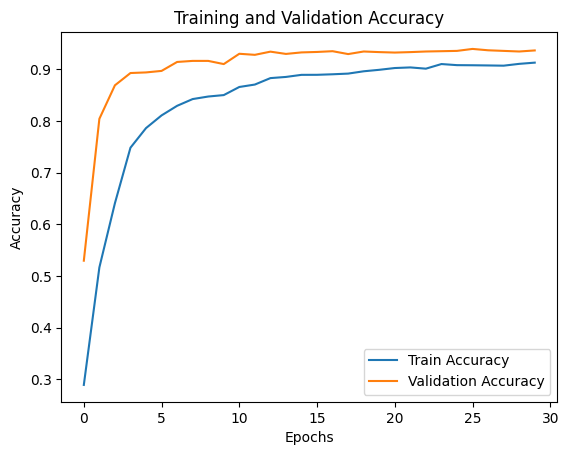

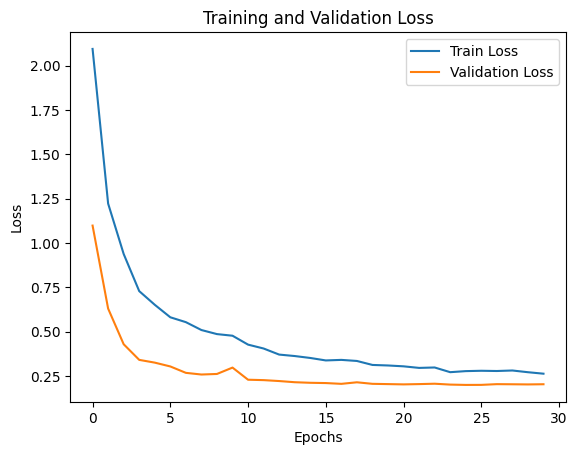

In [18]:
# Plotting training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')        # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot validation accuracy
plt.title('Training and Validation Accuracy')                        # Set the title for the plot
plt.xlabel('Epochs')                                                 # Label the x-axis as 'Epochs'
plt.ylabel('Accuracy')                                               # Label the y-axis as 'Accuracy'
plt.legend()                                                         # Display the legend
plt.show()                                                           # Show the plot

# Plotting training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')                # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')       # Plot validation loss
plt.title('Training and Validation Loss')                            # Set the title for the plot
plt.xlabel('Epochs')                                                 # Label the x-axis as 'Epochs'
plt.ylabel('Loss')                                                   # Label the y-axis as 'Loss'
plt.legend()                                                         # Display the legend
plt.show()                                                           # Show the plot

In [19]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(test_generator)  # Evaluate the model and get test loss and accuracy

# Convert accuracy to percentage
test_acc_percent = test_acc * 100                     # Convert test accuracy to percentage
val_acc_percent = history.history["val_accuracy"][-1] * 100  # Convert validation accuracy to percentage

# Print the test accuracy in percentage
print(f'Test accuracy: {test_acc_percent:.2f}%')      # Print the test accuracy as a percentage

# Print the final validation accuracy in percentage
print(f'Validation accuracy: {val_acc_percent:.2f}%') # Print the final validation accuracy as a percentage

107/107 [==============================] - 3s 31ms/step - loss: 0.2033 - accuracy: 0.9366
Test accuracy: 93.66%
Validation accuracy: 93.66%


## Model Conversion

##### *SavedFormat*

In [20]:
# Save the model in SavedModel format within the 'saved_model' directory
save_path = 'saved_model/'

# Save the model in the TensorFlow SavedModel format
tf.saved_model.save(model, save_path)

##### *TFJS*

In [23]:
!pip install tensorflowjs

  Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached ml_dtypes-0.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 67.0 MB/s eta 0:00:00
Using cached tensorflow-2.17.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (601.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.6 MB/s eta 0:00:00
Using cached ml_dtypes-0.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 75.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
    

In [1]:
# Convert the SavedModel to TensorFlow.js format and save it in the 'tfjs_model' directory
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2024-08-28 11:23:36.705841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 11:23:36.723355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 11:23:36.744620: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 11:23:36.751122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 11:23:36.766173: I tensorflow/core/platform/cpu_feature_guar

##### *TF-Lite*

In [21]:
# Ensure that the 'tflite' directory exists; create it if it doesn't
os.makedirs('tflite', exist_ok=True)

# Convert the SavedModel to TF-Lite format and save it in the 'tflite' directory
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Save the TF-Lite model to the file 'tflite/model.tflite'
tflite_model_path = 'tflite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [2]:
from google.colab import files
import zipfile
import os

# Name of the output zip file
zip_filename = 'models.zip'

# Directories to be zipped
directories = ['saved_model', 'tfjs_model', 'tflite']

# Create the zip file
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for directory in directories:
        # Add all the contents of each directory to the zip file
        for root, _, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file))

## Inference

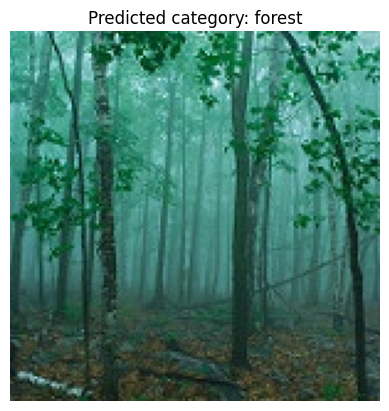

In [22]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='tflite/model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define the path to the directory containing images for prediction
prediction_dir = 'data/seg_pred/seg_pred'

# Categories
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Function to preprocess a single image for inference
def preprocess_image(img_path, target_size=(150, 150)):
    img = Image.open(img_path)  # Open the image using PIL
    img = img.resize(target_size) # Resize the image
    img = img.convert('RGB') # Convert to RGB
    img_array = tf.keras.preprocessing.image.img_to_array(img) # Convert to a NumPy array
    img_array = img_array / 255.0  # Normalize the image data to the range [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    return img_array

# Get a single image from the directory
image_files = [f for f in os.listdir(prediction_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
if image_files:
    img_name = image_files[5]
    img_path = os.path.join(prediction_dir, img_name)

    # Preprocess the image
    input_image = preprocess_image(img_path)

    # Set the tensor input
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Perform inference
    interpreter.invoke()

    # Get the output tensor
    output_tensor = interpreter.get_tensor(output_details[0]['index'])

    # Get the predicted class index
    predicted_class_index = np.argmax(output_tensor)

    # Get the predicted category
    predicted_category = categories[predicted_class_index]

    # Display the image and prediction
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Predicted category: {predicted_category}")
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No image files found in the directory.")